In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [81]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import random
import sklearn as sk
from time import time
import pickle


In [3]:
face_orig = open("data/facebook-links.txt") 
f_arr = np.array(face_orig.readlines())
G = nx.Graph()

edgelist = []
for line in f_arr: 
    i, j, time = line.split('\t')
    edgelist.append((int(i), int(j)))

G.add_edges_from(edgelist)


In [15]:
H = nx.Graph()

In [18]:
H.nodes()

[1, 2, 3]

In [19]:
H.edges()

[(1, 2), (1, 3)]

### Split the graph

In [25]:
def edge_split(G, alpha_v, save_as=""):
    V = np.array(G.edges())
    random.shuffle(V)
    a = int((1-alpha_v)/2 * len(V))
    b = int(alpha_v * len(V))
    Va = V[:a]
    Vb =  V[a:a+b]
    Vc =  V[a+b:2*a+b]
    V1 = np.concatenate((Va, Vb))
    V2 = np.concatenate((Vb, Vc))
    G1 = nx.Graph()
    G1.add_edges_from(V1)
    G2 = nx.Graph()
    G2.add_edges_from(V2)
    if save_as != '': 
        nx.write_edgelist(G1, 'data/'+str(alpha_v)+save_as+'_aux.edgelist')
        nx.write_edgelist(G2, 'data/'+str(alpha_v)+save_as+'_san.edgelist')
    return G1, G2

In [26]:
G1, G2 = edge_split(G, 0.25)

In [35]:
## Apply anonimization
def anonimize(G):
    return G
G_aux = anonimize(G1)
G_san = anonimize(G2)

In [34]:
str(G2.number_of_nodes())+  ' vs '  +  str(G2.number_of_edges())

'48277 vs 351388'

### Train data

In [36]:
G_a1, G_a2 = edge_split(G_aux, 0.25) # aux 
G_s1, G_s2 = edge_split(G_san, 0.25) # sanitized

In [83]:
'''
 Get the histogram of degree distribution for an node 'n' in a graph 'G' 
     bins - the number of bins in the deg. distribution 
     size - size of the historgram 
'''
def deg_dist(G, n, bins, size):
    feature_set = [0 for i in range(2*bins)]
    _1hop = G[n]
    _1hop = G.degree(_1hop).values()
    for h in _1hop:
        if h < bins*size:
            feature_set[int(h/size)] += 1
    _prev = set(nx.single_source_shortest_path_length(G, n, cutoff=1).keys())
    _2hop = set(nx.single_source_shortest_path_length(G, n, cutoff=2).keys())
    _2hop = _2hop - _prev
    _2hop = G.degree(_2hop).values()
    for h in _2hop:
        if h < bins*size:
            feature_set[bins+int(h/size)] += 1
    return feature_set


''' Get the feature vector for egde e1 in graph G1
     and e2 in graph G2.
     1hop, 2hop deg distributions
     + 4 Silhoutte coefficients
'''    
def e_feature(G1, e1, G2, e2,  bins = 21, size = 50):
    feature_set = [0 for i in range(8*bins)]
    for j in [0, 1]:
        f_set = deg_dist(G1, e1[j], bins, size)
        for i in range(len(f_set)):
            feature_set[2*bins*j + i] += f_set[i]
    for j in [0, 1]:
        f_set = deg_dist(G2, e2[j], bins, size)
        for i in range(len(f_set)):
            feature_set[4*bins+2*bins*j + i] += f_set[i]
    
    # 4 Silhouette Coefficients 
    e1_deg0 = G1.degree(e1[0])
    e1_deg1 = G1.degree(e1[1])
    
    e2_deg0 = G2.degree(e2[0])
    e2_deg1 = G2.degree(e2[1])
    
    feature_set.append(abs(e1_deg0-e2_deg0)/max(e1_deg0, e2_deg0, 1))
    feature_set.append(abs(e1_deg1-e2_deg1)/max(e1_deg1, e2_deg1, 1))
    feature_set.append(abs(e1_deg0-e2_deg1)/max(e1_deg0, e2_deg1, 1))
    feature_set.append(abs(e1_deg1-e2_deg0)/max(e1_deg1, e2_deg0, 1))
    
    return feature_set

'''
    Transform graph into feature vector dataset
    G1, G2 - graphs for comparison
'''
def fill_set(G1, G2, data, labels, n_max=None):
    indx = 0
    total = len(G1.nodes())
    # report every 10 % 
    part = total//10
    # Add all intersections first: 
    print('Start adding positive examples')
    common = set(G1.edges()) & set(G2.edges())
    if n_max is None: 
        n_max = len(common)
    common = random.sample(common, n_max)
    indx = 0
    for i in common: 
        data.append(e_feature(G1,i, G2, i))
        labels.append(1)
        indx += 1
        if indx % int(len(common)/10) ==0:
            print("Finished : " + str(indx/len(common)))
        
    g1 = set(G1.edges()) - set(common)
    g2 = set(G2.edges()) - set(common)
    
    # How many false results to add ? - 
    # The same size as common
    # TODO: 
    print('Start adding false examples')
    g1 = random.sample(g1, len(common))
    g2 = random.sample(g2, len(common))
    for i in range(len(g1)):
        data.append(e_feature(G1, g1[i], G2, g2[i]))
        labels.append(0)
        if i % int(len(g1)/10) ==0:
            print("Finished : " + str(i/len(g1)))

In [84]:
# Generating train dataset: 
train_set = []
train_labels = []
s = time()
print("Dataset is generating ... ")
fill_set(G_a1, G_a2, train_set, train_labels, n_max=10000)
e = time()
print("Aux finished " + str(e-s) + " sec")
s = time()
fill_set(G_s1, G_s2, train_set, train_labels, n_max=10000)
e = time()
print("San finished " + str(e-s) + " sec")
pickle.dump( (train_set, train_labels), open( "data/train_edge_face.set", "wb" ) )

Dataset is generating ... 
Start adding positive examples
Finished : 0.1
Finished : 0.2
Finished : 0.3
Finished : 0.4
Finished : 0.5
Finished : 0.6
Finished : 0.7
Finished : 0.8
Finished : 0.9
Finished : 1.0
Start adding false examples
Finished : 0.0
Finished : 0.1
Finished : 0.2
Finished : 0.3
Finished : 0.4
Finished : 0.5
Finished : 0.6
Finished : 0.7
Finished : 0.8
Finished : 0.9
Aux finished 617.014741897583 sec
Start adding positive examples
Finished : 0.1
Finished : 0.2
Finished : 0.3
Finished : 0.4
Finished : 0.5
Finished : 0.6
Finished : 0.7
Finished : 0.8
Finished : 0.9
Finished : 1.0
Start adding false examples
Finished : 0.0
Finished : 0.1
Finished : 0.2
Finished : 0.3
Finished : 0.4
Finished : 0.5
Finished : 0.6
Finished : 0.7
Finished : 0.8
Finished : 0.9
San finished 497.56792998313904 sec


In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
forest = RandomForestClassifier(n_estimators = 400, n_jobs=4)
forest.fit(train_set, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
test_set = []
test_labels = []
s = time()
print("Dataset is generating ... ")
fill_set(G_aux, G_san, test_set, test_labels, n_max=5000)
e = time()
print("Test set generated in  " + str(e-s) + " sec")
pickle.dump( (test_set, test_labels), open( "data/test_edge_face.set", "wb" ) )

Dataset is generating ... 
Start adding positive examples
Finished : 0.1
Finished : 0.2
Finished : 0.3
Finished : 0.4
Finished : 0.5
Finished : 0.6
Finished : 0.7
Finished : 0.8
Finished : 0.9
Finished : 1.0
Start adding false examples
Finished : 0.0
Finished : 0.1
Finished : 0.2
Finished : 0.3
Finished : 0.4
Finished : 0.5
Finished : 0.6
Finished : 0.7
Finished : 0.8
Finished : 0.9
Test set generated in  5003.551363945007 sec


In [89]:
forest.score(test_set, test_labels)

0.88649999999999995

In [92]:
from sklearn.metrics import roc_curve, auc
y_score = forest.predict_proba(test_set)
y_true = test_labels
fpr, tpr, thresholds = roc_curve(y_true, y_score[:, 1])
roc_auc = auc(fpr, tpr)

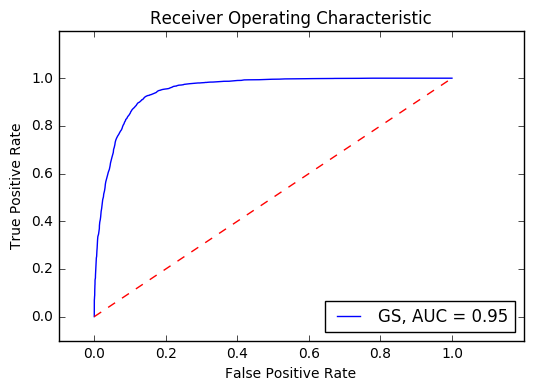

In [93]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='GS, AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()